## Use LDA topics as input features

Aim is to use LDA to generate the doc-topic model.
Once generated the topic distributions can form the input features.
As long as the number of topics is small enough, the 25 headlines can be kept as seperate documents.

Rather than choosing a value for the topic number, perplexities will be used to compute the optimal number.

In [1]:
# Import required packages
import pandas as pd
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Set seed
seed = 1984
np.random.seed(seed)

In [3]:
# Load training data
train = pd.read_csv("Datasets/Combined_News_DJIA_train.csv")

# First correct the nan records in the training data
train.set_value(277, 'Top23', "NA")
train.set_value(277, 'Top24', "NA")
train.set_value(277, 'Top25', "NA")
train.set_value(348, 'Top24', "NA")
train.set_value(348, 'Top25', "NA")
train.set_value(681, 'Top24', "NA")
train.set_value(681, 'Top25', "NA")
train['Top23'][277]

'NA'

In [4]:
# Use CountVectorizer to handle most of these in one step!
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

doc_array = train[[x for x in train.columns if 'Top' in x]].values.flatten()
print(doc_array[0])

# Convert to lowercase, stem and lemmatize
ls = LancasterStemmer
wl = WordNetLemmatizer()
#doc_array = [str(x).lower() for x in doc_array]
doc_array = [" ".join([wl.lemmatize(x.lower()) for x in CountVectorizer().build_tokenizer()(doc)]) for doc in doc_array]

print(doc_array[0])

tdm = vectorizer.fit_transform(doc_array)
tdm.shape

b"Georgia 'downs two Russian warplanes' as countries move to brink of war"
georgia down two russian warplane a country move to brink of war


(40275, 15653)

Save the TDM to a csv file for easy use later on

In [5]:
vocab = vectorizer.get_feature_names()
tdm_df = pd.DataFrame(data=tdm.todense(), columns=vocab)

tdm_df.to_csv('Basic_TDM.csv', index=False)

### Perplexities
Loop over a range of topic numbers, computing the perplexities for each 
(Data will need to be split into training and test subsets)

The perplxities are then plotted to determine the optimal number of topics to use for the model

In [6]:
# Split into train / test subsets

X_train, X_test = train_test_split(
    tdm_df.values, test_size=0.33, random_state=42)

X_train.shape

(26984, 15653)

In [9]:
# Setup intial vars

topic_nums = [i for i in range(1, 50)]
perplexities = []

# Evaluate the perplxities per topic number
for t in topic_nums:
    a = None #50.0 / t
    #b = 0.05
    b = None #0.012    # This corresponds to 200 / W
    lda = LatentDirichletAllocation(n_topics=t, max_iter=5,
                                    learning_method='batch',
                                    random_state=0,
                                    doc_topic_prior=a,
                                    topic_word_prior=b)

    lda.fit(X_train)

    test_gamma = lda.transform(X_test)
    perp = lda.perplexity(X_test, test_gamma)
    perplexities.append(perp)
    print(t, perp)

1 4753.55159486
2 8686.06494757
3 18291.9406317
4 45018.1947929
5 110121.170327
6 265833.72247
7 623108.679341
8 1467702.97092
9 3382869.79683
10 7825884.81791
11 18100914.4447
12 41311314.6539
13 95501315.3145
14 215429931.35
15 491434739.1
16 1136707027.39
17 2606757170.24
18 5826510317.16
19 13597517067.3
20 30927965464.9
21 69632435602.9
22 157007974137.0
23 355804157054.0
24 817992322206.0
25 1.8223333977e+12
26 3.99062245925e+12
27 8.75594228567e+12
28 1.94570756282e+13
29 4.14741142364e+13
30 9.63148490254e+13
31 2.15942986804e+14
32 4.74255892092e+14
33 1.08934799564e+15
34 2.53297205508e+15
35 5.58385837513e+15
36 1.27084003939e+16
37 2.86124782989e+16
38 6.6389710652e+16
39 1.46608119731e+17
40 3.21926286478e+17
41 7.46123437398e+17
42 1.64376760503e+18
43 3.75172910902e+18
44 8.30816859051e+18
45 1.8826108903e+19
46 4.27239741688e+19
47 9.55211434173e+19
48 2.10099841127e+20
49 4.82732217814e+20


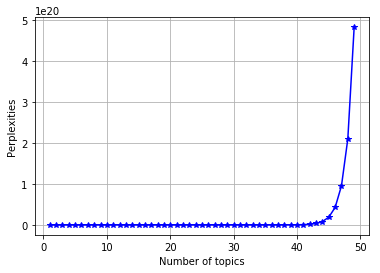

In [10]:
# Plot the computed perplexity values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(topic_nums, perplexities, 'b*-')
plt.grid(True)
plt.xlabel('Number of topics')
plt.ylabel('Perplexities')
plt.show()